In [1]:
#Import all the necessary python libraries
import os
import pandas as pd
import numpy as np

import json
import pymzml
import csv
import re
from tqdm import tqdm

import warnings

import plotly.graph_objs as go
from scipy.integrate import trapz
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture


#######################################
### FIX AND DOUBLE CHECK LATER#######
#################################
#CLAW made directories 
import create_directory
import CLAW
import OzESI_CLAW
# import OzESI
# import OzESI_plot
# import OzESI_compare

#version 2
import OzESI
from OzESI_plot import Plot
# Import the create_folder function from OzESI_utils
from OzESI_utils import create_folder, create_base_directory, generate_filename, save_for_ozone_compare, create_project_folder, filter_o3mzml_files, create_all_folders
from OzESI_compare import OzoneCompare

# Suppress all warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



# Set Directories to load and save

In [2]:


# Define the mode: 'ON' or 'OFF'
mode = 'ON'  # Change to 'ON' as needed

# Project Directory
project = './Projects/'

# Project Name
project_name = 'AMP' #name of project
project_data_name = 'AMP' #name of data from project

project_folder_data = f'{project}{project_name}/AMP_ON/'
project_results_folder = f'{project}{project_name}/results/'

#mzML Data
mzml_data = f'{project}{project_name}/mzml/AMP_ON/' #mzML Parse

#CSV Data
csv_data_folder = f'{project_results_folder}csv_data/'


grouped_data_csv = f"{csv_data_folder}{project_data_name}_LipidGrouper_{mode}.csv" # Save RawDataParser output CSV file
matched_data_csv = f"{csv_data_folder}{project_data_name}_MatchedData_{mode}.csv" # Save MatchedData output CSV file
peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_{mode}.csv" # Path to the PeakAnalysis output CSV file

#dont need?
# # Paths to the CSV files
# mrm_csv_path = f'{csv_data_folder}df_MRM_{mode}.csv'
# oze_esi_csv_path = f'{csv_data_folder}df_OzESI_{mode}.csv'

#plot data
plots_directory = f'Projects/{project_name}/results/{project_data_name}/plots/on/'

#Database Locations
OzON_database = 'lipid_database/OzON_databases/OzON_Possible_Database.csv' ##double check this is right
OzOFF_database = f'{csv_data_folder}{project_name}_OzOFF_possible.csv'



# Define all necessary folder paths
folders_to_create = [
    csv_data_folder,
    plots_directory,
    project_results_folder,
    plots_directory
]

# Call the function to ensure all folders exist
create_all_folders(*folders_to_create)



Folder already exists: ./Projects/AMP/results/csv_data/
Folder already exists: Projects/AMP/results/AMP/plots/on/
Folder already exists: ./Projects/AMP/results/
Folder already exists: Projects/AMP/results/AMP/plots/on/


### MZML PARSER

In [3]:

# class MzMLParser:
#     def __init__(self):
#         # Initialize DataFrames to store parsed data
#         self.transition_summed_df = pd.DataFrame(columns=[
#             'Parent_Ion', 
#             'Product_Ion', 
#             'Intensity', 
#             'Transition', 
#             'Sample_ID'
#         ])
#         self.OzESI_df = pd.DataFrame(columns=[
#             'Lipid',
#             'Parent_Ion', 
#             'Product_Ion', 
#             'Retention_Time', 
#             'OzESI_Intensity', 
#             'Sample_ID', 
#             'Transition'
#         ])
#         self.time_and_intensity_df = pd.DataFrame(columns=['Time', 'Intensity'])

#     def mzml_parser(self, file_path, plot_chromatogram=False):
#         """
#         Parses a single mzML file and updates the DataFrames with parsed data.

#         Parameters:
#         file_path (str): The path to the mzML file to be parsed.
#         plot_chromatogram (bool): Flag to indicate whether to plot the chromatogram (default is False).
#         """
#         rows = []
#         ozesi_rows = []

#         # Read the mzML file using pymzml
#         run = pymzml.run.Reader(file_path, skip_chromatogram=False)
#         q1_mz = 0  # Initialize Q1 mass-to-charge ratio
#         q3_mz = 0  # Initialize Q3 mass-to-charge ratio

#         # Iterate through each spectrum in the mzML file
#         for spectrum in run:
#             # Extract Q1 and Q3 values from the spectrum ID
#             for element in spectrum.ID.split(' '):
#                 if 'Q1' in element:
#                     q1 = element.split('=')
#                     q1_mz = np.round(float(q1[1]), 1)

#                 if 'Q3' in element:
#                     q3 = element.split('=')
#                     q3_mz = np.round(float(q3[1]), 1)

#                     # Calculate the sum of intensities for the peaks in the spectrum
#                     intensity_store = np.array([intensity for _, intensity in spectrum.peaks()])
#                     intensity_sum = np.sum(intensity_store)

#                     # Construct the transition string
#                     transition = f"{q1_mz} -> {q3_mz}"
#                     # Extract sample ID from the file name
#                     sample_id = os.path.basename(file_path)[:-5]

#                     # Append parsed data to the rows list
#                     rows.append({
#                         'Parent_Ion': q1_mz,
#                         'Product_Ion': q3_mz,
#                         'Intensity': intensity_sum,
#                         'Transition': transition,
#                         'Sample_ID': sample_id
#                     })

#                     # Append time and intensity data to ozesi_rows list
#                     for time, intensity in spectrum.peaks():
#                         ozesi_rows.append({
#                             'Parent_Ion': q1_mz,
#                             'Product_Ion': q3_mz,
#                             'Retention_Time': time,
#                             'OzESI_Intensity': intensity,
#                             'Sample_ID': sample_id,
#                             'Transition': transition
#                         })

#         # Convert rows list to a DataFrame and append it to transition_summed_df
#         df = pd.DataFrame(rows)
#         self.OzESI_df = self.OzESI_df.append(pd.DataFrame(ozesi_rows), ignore_index=True)
#         self.transition_summed_df = self.transition_summed_df.append(df, ignore_index=True)
#         print(f'Finished parsing mzML file: {file_path}\n')

#     def mzml_parser_batch(self, folder_name, plot_chromatogram=False):
#         """
#         Parses all mzML files in a given directory and updates the DataFrames.

#         Parameters:
#         folder_name (str): The path to the directory containing mzML files.
#         plot_chromatogram (bool): Flag to indicate whether to plot the chromatogram (default is False).
#         """
#         # List all files in the directory and sort them
#         data_folder = os.listdir(folder_name)
#         data_folder.sort()

#         # Iterate through each file in the directory
#         for file in data_folder:
#             # Process only mzML files
#             if file.endswith('.mzML'):
#                 file_path = os.path.join(folder_name, file)
#                 self.mzml_parser(file_path, plot_chromatogram=plot_chromatogram)

#         print('Finished parsing all mzML files\n')

#     def get_transition_summed_df(self):
#         """
#         Returns the DataFrame containing the summed transition data.

#         Returns:
#         pd.DataFrame: The transition_summed_df DataFrame.
#         """
#         return self.transition_summed_df

#     def get_OzESI_df(self):
#         """
#         Returns the DataFrame containing the OzESI data.

#         Returns:
#         pd.DataFrame: The OzESI_df DataFrame.
#         """
#         return self.OzESI_df

# # Example usage:

# parser = MzMLParser()
# parser.mzml_parser_batch(mzml_data)

# # To view the DataFrames
# transition_summed_df = parser.get_transition_summed_df()
# OzESI_df = parser.get_OzESI_df()

# print(transition_summed_df)
# print(OzESI_df)


# MZML parser added tqdm

In [4]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import pymzml
import os

class MzMLParser:
    def __init__(self):
        # Initialize DataFrames to store parsed data
        self.transition_summed_df = pd.DataFrame(columns=[
            'Parent_Ion', 
            'Product_Ion', 
            'Intensity', 
            'Transition', 
            'Sample_ID'
        ])
        self.OzESI_df = pd.DataFrame(columns=[
            'Lipid',
            'Parent_Ion', 
            'Product_Ion', 
            'Retention_Time', 
            'OzESI_Intensity', 
            'Sample_ID', 
            'Transition'
        ])
        self.time_and_intensity_df = pd.DataFrame(columns=['Time', 'Intensity'])

    def mzml_parser(self, file_path, plot_chromatogram=False):
        """
        Parses a single mzML file and updates the DataFrames with parsed data.

        Parameters:
        file_path (str): The path to the mzML file to be parsed.
        plot_chromatogram (bool): Flag to indicate whether to plot the chromatogram (default is False).
        """
        rows = []
        ozesi_rows = []

        # Read the mzML file using pymzml
        run = pymzml.run.Reader(file_path, skip_chromatogram=False)
        q1_mz = 0  # Initialize Q1 mass-to-charge ratio
        q3_mz = 0  # Initialize Q3 mass-to-charge ratio

        # Iterate through each spectrum in the mzML file
        for spectrum in run:
            # Extract Q1 and Q3 values from the spectrum ID
            for element in spectrum.ID.split(' '):
                if 'Q1' in element:
                    q1 = element.split('=')
                    q1_mz = np.round(float(q1[1]), 1)

                if 'Q3' in element:
                    q3 = element.split('=')
                    q3_mz = np.round(float(q3[1]), 1)

                    # Calculate the sum of intensities for the peaks in the spectrum
                    intensity_store = np.array([intensity for _, intensity in spectrum.peaks()])
                    intensity_sum = np.sum(intensity_store)

                    # Construct the transition string
                    transition = f"{q1_mz} -> {q3_mz}"
                    # Extract sample ID from the file name
                    sample_id = os.path.basename(file_path)[:-5]

                    # Append parsed data to the rows list
                    rows.append({
                        'Parent_Ion': q1_mz,
                        'Product_Ion': q3_mz,
                        'Intensity': intensity_sum,
                        'Transition': transition,
                        'Sample_ID': sample_id
                    })

                    # Append time and intensity data to ozesi_rows list
                    for time, intensity in spectrum.peaks():
                        ozesi_rows.append({
                            'Parent_Ion': q1_mz,
                            'Product_Ion': q3_mz,
                            'Retention_Time': time,
                            'OzESI_Intensity': intensity,
                            'Sample_ID': sample_id,
                            'Transition': transition
                        })

        # Convert rows list to a DataFrame and append it to transition_summed_df
        df = pd.DataFrame(rows)
        self.OzESI_df = self.OzESI_df.append(pd.DataFrame(ozesi_rows), ignore_index=True)
        self.transition_summed_df = self.transition_summed_df.append(df, ignore_index=True)
        print(f'Finished parsing mzML file: {file_path}\n')

    def mzml_parser_batch(self, folder_name, plot_chromatogram=False):
        """
        Parses all mzML files in a given directory and updates the DataFrames.

        Parameters:
        folder_name (str): The path to the directory containing mzML files.
        plot_chromatogram (bool): Flag to indicate whether to plot the chromatogram (default is False).
        """
        # List all files in the directory and sort them
        data_folder = os.listdir(folder_name)
        data_folder.sort()

        # Iterate through each file in the directory with a progress bar
        for file in tqdm(data_folder, desc="Parsing mzML files"):
            # Process only mzML files
            if file.endswith('.mzML'):
                file_path = os.path.join(folder_name, file)
                self.mzml_parser(file_path, plot_chromatogram=plot_chromatogram)

        print('Finished parsing all mzML files\n')

    def get_transition_summed_df(self):
        """
        Returns the DataFrame containing the summed transition data.

        Returns:
        pd.DataFrame: The transition_summed_df DataFrame.
        """
        return self.transition_summed_df

    def get_OzESI_df(self):
        """
        Returns the DataFrame containing the OzESI data.

        Returns:
        pd.DataFrame: The OzESI_df DataFrame.
        """
        return self.OzESI_df

# Example usage:

parser = MzMLParser()
parser.mzml_parser_batch(mzml_data)

# To view the DataFrames
transition_summed_df = parser.get_transition_summed_df()
OzESI_df = parser.get_OzESI_df()

print(transition_summed_df)
print(OzESI_df)



Parsing mzML files:   2%|▏         | 1/42 [00:00<00:34,  1.19it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_Blank-AMP_2x_MRMs_O3on_01.mzML



Parsing mzML files:   5%|▍         | 2/42 [00:01<00:33,  1.20it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:   7%|▋         | 3/42 [00:02<00:28,  1.36it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  10%|▉         | 4/42 [00:03<00:28,  1.34it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m1-dienc-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  12%|█▏        | 5/42 [00:03<00:28,  1.28it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m1-hippo-FAD245_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  14%|█▍        | 6/42 [00:04<00:28,  1.26it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m2-cereb-FAD246_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  17%|█▋        | 7/42 [00:05<00:28,  1.23it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m2-cortex-FAD249_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  19%|█▉        | 8/42 [00:06<00:27,  1.25it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m2-dienc-FAD249_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  21%|██▏       | 9/42 [00:07<00:27,  1.19it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m2-hippo-FAD249_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  24%|██▍       | 10/42 [00:08<00:26,  1.19it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m3-cereb-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  26%|██▌       | 11/42 [00:09<00:26,  1.16it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m3-cortex-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  29%|██▊       | 12/42 [00:09<00:26,  1.14it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m3-dienc-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  31%|███       | 13/42 [00:10<00:25,  1.15it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m3-hippo-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  33%|███▎      | 14/42 [00:11<00:24,  1.12it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m4-cereb-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  36%|███▌      | 15/42 [00:12<00:24,  1.12it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m4-cortex-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  38%|███▊      | 16/42 [00:13<00:24,  1.08it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m4-cortex-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_02.mzML



Parsing mzML files:  40%|████      | 17/42 [00:14<00:23,  1.08it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m4-dienc-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  43%|████▎     | 18/42 [00:15<00:22,  1.06it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m4-hippo-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  45%|████▌     | 19/42 [00:16<00:21,  1.05it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m5-cereb-FAD259_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  48%|████▊     | 20/42 [00:17<00:21,  1.01it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m5-cereb-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  50%|█████     | 21/42 [00:18<00:20,  1.02it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m5-cortex-FAD259_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  52%|█████▏    | 22/42 [00:19<00:19,  1.05it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m5-cortex-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  55%|█████▍    | 23/42 [00:20<00:17,  1.10it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m5-dienc-FAD259_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  57%|█████▋    | 24/42 [00:21<00:16,  1.11it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m5-dienc-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  60%|█████▉    | 25/42 [00:22<00:16,  1.05it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m5-hippo-FAD259_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  62%|██████▏   | 26/42 [00:23<00:15,  1.01it/s]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11162023_WT-m5-hippo-FAD263_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  64%|██████▍   | 27/42 [00:24<00:15,  1.03s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m1-cereb-FAD231_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  67%|██████▋   | 28/42 [00:25<00:14,  1.06s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m1-cereb-FAD249_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  69%|██████▉   | 29/42 [00:26<00:14,  1.09s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m1-cortex-FAD231_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  71%|███████▏  | 30/42 [00:27<00:12,  1.05s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m1-cortex-FAD249_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  74%|███████▍  | 31/42 [00:28<00:11,  1.07s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m1-dienc-FAD231_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  76%|███████▌  | 32/42 [00:29<00:11,  1.11s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m1-dienc-FAD249_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  79%|███████▊  | 33/42 [00:31<00:09,  1.11s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m1-hippo-FAD231_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  81%|████████  | 34/42 [00:32<00:09,  1.15s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m1-hippo-FAD249_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  83%|████████▎ | 35/42 [00:33<00:08,  1.15s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m2-cereb-FAD231_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  86%|████████▌ | 36/42 [00:34<00:07,  1.19s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m2-cereb-FAD257_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  88%|████████▊ | 37/42 [00:35<00:05,  1.17s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m2-cortex-FAD231_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  90%|█████████ | 38/42 [00:37<00:05,  1.25s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m2-cortex-FAD257_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  93%|█████████▎| 39/42 [00:38<00:03,  1.24s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m2-dienc-FAD231_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  95%|█████████▌| 40/42 [00:39<00:02,  1.27s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m2-dienc-FAD257_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files:  98%|█████████▊| 41/42 [00:41<00:01,  1.26s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m2-hippo-FAD231_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML



Parsing mzML files: 100%|██████████| 42/42 [00:42<00:00,  1.01s/it]

Finished parsing mzML file: ./Projects/AMP/mzml/AMP_ON/11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd216-0_MRMs_O3on_01.mzML

Finished parsing all mzML files

      Parent_Ion  Product_Ion      Intensity      Transition  \
0          227.1        183.0  128625.429199  227.1 -> 183.0   
1          241.1        183.0   94654.506634  241.1 -> 183.0   
2          255.2        183.0  160096.651577  255.2 -> 183.0   
3          269.1        183.0  149254.590614  269.1 -> 183.0   
4          283.2        183.0  479790.393131  283.2 -> 183.0   
...          ...          ...            ...             ...   
2305       507.4        183.0  344062.144516  507.4 -> 183.0   
2306       521.4        183.0  122595.628666  521.4 -> 183.0   
2307       533.4        183.0  108715.907707  533.4 -> 183.0   
2308       535.4        183.0  147683.770336  535.4 -> 183.0   
2309       533.5        183.0   96466.166779  533.5 -> 183.0   

                                              Sample_ID  
0              

In [5]:
transition_summed_df.head()

,Parent_Ion,Product_Ion,Intensity,Transition,Sample_ID
0,227.1,183.0,128625.429199,227.1 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01
1,241.1,183.0,94654.506634,241.1 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01
2,255.2,183.0,160096.651577,255.2 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01
3,269.1,183.0,149254.590614,269.1 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01
4,283.2,183.0,479790.393131,283.2 -> 183.0,11162023_Blank-AMP_2x_MRMs_O3on_01


In [17]:
OzESI_df

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,227.1,183.0,0.011583,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
1,NaN,227.1,183.0,0.024483,40.680004,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
2,NaN,227.1,183.0,0.037383,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
3,NaN,227.1,183.0,0.050317,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
4,NaN,227.1,183.0,0.063233,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
...,...,...,...,...,...,...,...
5121228,NaN,533.5,183.0,29.949033,41.620003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121229,NaN,533.5,183.0,29.961967,41.600002,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121230,NaN,533.5,183.0,29.974883,41.540005,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121231,NaN,533.5,183.0,29.987800,41.480003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0


# Import the 3 DFs A = OzOFF possibile, B = OzON Database, C = OzON Data

In [15]:
OzOFF_database = pd.read_csv('Projects/AMP/results/csv_data/OzOFF_Possible_species.csv') # A
# Keep only the first 5 rows
################ DO THIS TO MAKE DEVELOP GO MUST FASTER, REMOVE AFTER DEVELOPMENT DONE
#OzOFF_database = OzOFF_database.iloc[20:25]

OzON_database = pd.read_csv('lipid_database/OzON_databases/OzON_Possible_Database_0.csv') # B
OzESI_df # C


,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,227.1,183.0,0.011583,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
1,NaN,227.1,183.0,0.024483,40.680004,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
2,NaN,227.1,183.0,0.037383,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
3,NaN,227.1,183.0,0.050317,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
4,NaN,227.1,183.0,0.063233,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
...,...,...,...,...,...,...,...
5121228,NaN,533.5,183.0,29.949033,41.620003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121229,NaN,533.5,183.0,29.961967,41.600002,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121230,NaN,533.5,183.0,29.974883,41.540005,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121231,NaN,533.5,183.0,29.987800,41.480003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0


In [16]:
# Assuming OzOFF_database is your DataFrame
# Display the first few rows of OzOFF_database
print(OzOFF_database.head())

# Keep only the first 5 rows
################ DO THIS TO MAKE DEVELOP GO MUST FASTER, REMOVE AFTER DEVELOPMENT DONE
# OzOFF_database = OzOFF_database.iloc[:21]

# Display the updated DataFrame to verify
OzOFF_database #A


                                           Sample_ID Lipid  Retention_Time  \
0  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  10:0            4.05   
1  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  11:0            4.36   
2  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  12:0            4.81   
3  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  13:0            5.31   
4  11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...  14:0            6.33   

  Species  OzESI_Intensity Sample  Retention_Time_Median  
0    10:0    163130.656250  Blank                   4.05  
1    11:0     28590.121094  Blank                   4.35  
2    12:0    277318.875000  Blank                   4.80  
3    13:0     21738.460938  Blank                   5.49  
4    14:0    832092.250000  Blank                   6.27  


,Sample_ID,Lipid,Retention_Time,Species,OzESI_Intensity,Sample,Retention_Time_Median
0,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,10:0,4.05,10:0,1.631307e+05,Blank,4.05
1,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,11:0,4.36,11:0,2.859012e+04,Blank,4.35
2,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,12:0,4.81,12:0,2.773189e+05,Blank,4.80
3,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,13:0,5.31,13:0,2.173846e+04,Blank,5.49
4,11162023_Blank-AMP_2x_MRMs_O3off_01_nan_nan_na...,14:0,6.33,14:0,8.320922e+05,Blank,6.27
...,...,...,...,...,...,...,...
1318,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,7:0,3.34,7:0,7.799356e+04,hippo_5xFAD_m2_FAD257,3.34
1319,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,8:0,3.60,8:0,2.943935e+05,hippo_5xFAD_m2_FAD257,3.60
1320,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,9:0,3.83,9:0,2.685991e+06,hippo_5xFAD_m2_FAD257,3.83
1321,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,9:1,3.71,9:1,5.000660e+03,hippo_5xFAD_m2_FAD257,3.71


In [9]:
OzON_database #B

,Lipid,Parent_Ion,Product_Ion,Species,Class,DB Location,FA mass,[FA+AMP]+
0,FA(5:0),269.3,183.0,5:0,FA,NaN,102.2,281.3
1,FA(6:0),283.3,183.0,6:0,FA,NaN,116.2,295.3
2,FA(6:1)_<>_n-2,269.2,183.0,6:1,FA,<>,114.1,281.2
3,FA(6:1)_<>_n-3,255.2,183.0,6:1,FA,<>,114.1,281.2
4,FA(6:1)_<>_n-4,241.2,183.0,6:1,FA,<>,114.1,281.2
...,...,...,...,...,...,...,...,...
6531,FA(30:6)_<BBFFF>_n-26,265.5,183.0,30:6,FA,<BBFFF>,440.4,607.5
6532,FA(30:6)_<FFFFF>_n-27,255.5,183.0,30:6,FA,<FFFFF>,440.4,607.5
6533,FA(30:6)_<BFFFF>_n-27,253.5,183.0,30:6,FA,<BFFFF>,440.4,607.5
6534,FA(30:6)_<FFFFF>_n-28,241.5,183.0,30:6,FA,<FFFFF>,440.4,607.5


In [10]:
OzESI_df #C

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition
0,NaN,227.1,183.0,0.011583,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
1,NaN,227.1,183.0,0.024483,40.680004,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
2,NaN,227.1,183.0,0.037383,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
3,NaN,227.1,183.0,0.050317,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
4,NaN,227.1,183.0,0.063233,40.640003,11162023_Blank-AMP_2x_MRMs_O3on_01,227.1 -> 183.0
...,...,...,...,...,...,...,...
5121228,NaN,533.5,183.0,29.949033,41.620003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121229,NaN,533.5,183.0,29.961967,41.600002,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121230,NaN,533.5,183.0,29.974883,41.540005,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0
5121231,NaN,533.5,183.0,29.987800,41.480003,11192023_5xFAD-m2-hippo-FAD257_AMP_2x_0.05uMd2...,533.5 -> 183.0


# Add Sample Column to OzESI_df

In [47]:
class SampleIDExtract:
    def __init__(self, new_columns=None):
        if new_columns is None:
            new_columns = {
                'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
                'Genotype': ['5xFAD', 'WT'],
                'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
                'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
                'Other': ['Blank', 'blank']
            }
        self.new_columns = new_columns

    def extract_sample_parts(self, sample_id):
        # Split the Sample_ID by both underscore and hyphen
        parts = sample_id.replace('-', '_').split('_')
        # Initialize a list to store matched parts
        matched_parts = []
        added_parts = set()

        # Identify parts that match the expected patterns
        for part in parts:
            for key in self.new_columns:
                for value in self.new_columns[key]:
                    if value in part and part not in added_parts:
                        matched_parts.append(value)
                        added_parts.add(part)
                        break

        # Join the relevant parts to create the Sample value
        return '_'.join(matched_parts)

    def apply_extraction(self, df):
        # Apply the extract_sample_parts function to each Sample_ID
        df['Sample'] = df['Sample_ID'].apply(self.extract_sample_parts)
        return df

# Example usage
new_columns = {
    'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
    'Genotype': ['5xFAD', 'WT'],
    'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
    'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
    'Other': ['Blank', 'blank']
}

# Create an instance of the class
sample_extractor = SampleIDExtract(new_columns)

# Apply the extraction
OzON_Data = sample_extractor.apply_extraction(OzESI_df)



In [48]:
#print unique values in the Sample column
OzON_Data['Sample'].unique()
#OzON_Data

array(['Blank', 'WT_m1_cereb_FAD245', 'WT_m1_cortex_FAD245',
       'WT_m1_dienc_FAD245', 'WT_m1_hippo_FAD245', 'WT_m2_cereb_FAD246',
       'WT_m2_cortex_FAD249', 'WT_m2_dienc_FAD249', 'WT_m2_hippo_FAD249',
       'WT_m3_cereb_FAD263', 'WT_m3_cortex_FAD263', 'WT_m3_dienc_FAD263',
       'WT_m3_hippo_FAD263', 'WT_m4_cereb_FAD263', 'WT_m4_cortex_FAD263',
       'WT_m4_dienc_FAD263', 'WT_m4_hippo_FAD263', 'WT_m5_cereb_FAD259',
       'WT_m5_cereb_FAD263', 'WT_m5_cortex_FAD259', 'WT_m5_cortex_FAD263',
       'WT_m5_dienc_FAD259', 'WT_m5_dienc_FAD263', 'WT_m5_hippo_FAD259',
       'WT_m5_hippo_FAD263', '5xFAD_m1_cereb_FAD231',
       '5xFAD_m1_cereb_FAD249', '5xFAD_m1_cortex_FAD231',
       '5xFAD_m1_cortex_FAD249', '5xFAD_m1_dienc_FAD231',
       '5xFAD_m1_dienc_FAD249', '5xFAD_m1_hippo_FAD231',
       '5xFAD_m1_hippo_FAD249', '5xFAD_m2_cereb_FAD231',
       '5xFAD_m2_cereb_FAD257', '5xFAD_m2_cortex_FAD231',
       '5xFAD_m2_cortex_FAD257', '5xFAD_m2_dienc_FAD231',
       '5xFAD_m2_dienc_

# OzON Filtering Code beginning

# MATCH LIPIDS

# match lipids with median RT

In [49]:
class MatchLipids:
    def __init__(self, mrm_database, tolerance=0.3):
        """
        Initialize the Match_Lipids class.

        :param mrm_database: DataFrame containing the MRM database with ion information.
        :param tolerance: Tolerance value for matching ion values.
        """
        self.mrm_database = mrm_database
        self.tolerance = tolerance
        
        # Round the ion values in the MRM database for easier comparison
        self.mrm_database['Parent_Ion'] = np.round(self.mrm_database['Parent_Ion'], 1)
        self.mrm_database['Product_Ion'] = np.round(self.mrm_database['Product_Ion'], 1)

    def within_tolerance(self, values1, values2):
        """
        Checks if two arrays of values are within a specified tolerance.

        :param values1: First array of values to compare.
        :param values2: Second array of values to compare.
        :return: Array of booleans indicating if the values are within tolerance.
        """
        return np.abs(values1 - values2) <= self.tolerance

    def match_lipids_parser(self, df):
        """
        Performs lipid matching by vectorized comparison of ion values.

        :param df: DataFrame containing ion information to be matched.
        :return: DataFrame with matched lipid and class information if matches were found.
        """
        # Round the ion values in the input DataFrame for easier comparison
        df['Parent_Ion'] = np.round(df['Parent_Ion'], 1)
        df['Product_Ion'] = np.round(df['Product_Ion'], 1)
        # Round OzESI_Intensity
        df['OzESI_Intensity'] = np.round(df['OzESI_Intensity'], 0)
        
        matched_lipids = []  # List to store matched lipid names
        matched_classes = []  # List to store matched lipid classes

        # Iterate through each row of the input DataFrame with progress bar
        for _, row in tqdm(df.iterrows(), total=len(df), desc="Matching Lipids"):
            # Check for matches within the specified tolerance
            parent_ion_matches = self.within_tolerance(self.mrm_database['Parent_Ion'].values, row['Parent_Ion'])
            product_ion_matches = self.within_tolerance(self.mrm_database['Product_Ion'].values, row['Product_Ion'])
            matches = parent_ion_matches & product_ion_matches
            
            # If matches are found, append the matched lipid and class information
            if np.any(matches):
                matched_lipids.append(' | '.join(self.mrm_database.loc[matches, 'Lipid'].values))
                matched_classes.append(' | '.join(self.mrm_database.loc[matches, 'Class'].values))
            else:
                matched_lipids.append('')
                matched_classes.append('')
        
        # Add the matched lipid and class information to the DataFrame
        df['Lipid'] = matched_lipids
        df['Class'] = matched_classes
        
        return df

    @staticmethod
    def run_match_lipids(OzOFF_database, OzON_database, OzESI_df, tolerance=0.3, retention_time_window=0.5, output_csv_path=None, match_on_median=False):
        """
        Function to match lipids between OzOFF and OzON databases and filter OzESI data based on retention time.
        
        Parameters:
        OzOFF_database (pd.DataFrame): DataFrame containing OzOFF database information.
        OzON_database (pd.DataFrame): DataFrame containing OzON database information.
        OzESI_df (pd.DataFrame): DataFrame containing OzESI data.
        tolerance (float): Tolerance value for matching lipids.
        retention_time_window (float): Retention time window for filtering OzESI data.
        output_csv_path (str): Path to save the matched results CSV file.
        match_on_median (bool): If True, match on Retention_Time_Median; otherwise, match on Retention_Time.
        
        Returns:
        pd.DataFrame: DataFrame containing the matched and filtered results.
        """
        # Initialize an empty DataFrame to store the master results
        OzON_results_df = pd.DataFrame()

        # Use isin() to filter OzON_database where Lipid matches any Species in OzOFF_database
        species_list = OzOFF_database['Species'].tolist()
        temp_OzON_database = OzON_database[OzON_database['Species'].isin(species_list)]

        # Initialize the Match_Lipids class
        matcher = MatchLipids(temp_OzON_database, tolerance=tolerance)

        # Select the appropriate retention time column
        retention_time_column = 'Retention_Time_Median' if match_on_median else 'Retention_Time'

        # Iterate through rows in OzOFF_database with tqdm progress bar
        for index, row in tqdm(OzOFF_database.iterrows(), total=len(OzOFF_database), desc="Processing OzOFF Database"):
            species = row['Species']
            retention_time_value = row[retention_time_column]
            
            # Further filter the OzESI_df by Retention_Time within ±retention_time_window
            filtered_OzESI = OzESI_df[
                (OzESI_df['Retention_Time'] >= (retention_time_value - retention_time_window)) &
                (OzESI_df['Retention_Time'] <= (retention_time_value + retention_time_window))
            ].copy()  # Use .copy() to avoid SettingWithCopyWarning
            
            # Add a new column 'Species' to store the respective information
            filtered_OzESI.loc[:, 'Species'] = species
            
            # Initialize a temporary DataFrame for the current iteration
            temp_OzON_data = filtered_OzESI.copy()

            # Match lipids for the current filtered data
            matched_temp_OzON_data = matcher.match_lipids_parser(temp_OzON_data)
            
            # Append the results to the master DataFrame
            OzON_results_df = pd.concat([OzON_results_df, matched_temp_OzON_data], ignore_index=True)

        # Save the results to a CSV file if an output path is provided
        if output_csv_path:
            OzON_results_df.to_csv(output_csv_path, index=False)

        # Return the results DataFrame
        return OzON_results_df



In [50]:
# User-defined variables
tolerance = 0.3  # Set your tolerance value here
retention_time_window = 0.5  # Set your retention time window here
matched_data_csv = f"{csv_data_folder}{project_data_name}_MatchedData_{mode}.csv"  # Save MatchedData output CSV file
match_on_median = True  # Set to True if you want to match on Retention_Time_Median

# Run the function with user-defined variables, including match_on_median
OzON_results = MatchLipids.run_match_lipids(
    OzOFF_database, 
    OzON_database, 
    OzESI_df, 
    tolerance=tolerance, 
    retention_time_window=retention_time_window, 
    output_csv_path=matched_data_csv, 
    match_on_median=match_on_median
)

print("Filtered OzON Database Matches:")
print(OzON_results.head())


/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/home/iyer95/.conda/envs/CLA/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
Processing OzOFF Database:   0%|          | 2/1323 [01:46<19:36:28, 53.44s/it]


KeyboardInterrupt: 

# SAVE MATCHED LIPIDS

In [15]:
print(OzON_results['Lipid'].dtypes)
print(OzON_results['Species'].dtypes)
print(OzON_results['Lipid'].unique())
OzON_results.to_csv('OzON_06jul24_matched_RT05.csv', index=False)
OzON_results

object
object
[''
 'FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_n-8 | FA(12:1)_<>_n-10 | FA(13:1)_<>_n-11 | FA(14:1)_<>_n-12 | FA(15:1)_<>_n-13 | FA(15:2)_<F>_n-13 | FA(15:3)_<FF>_n-13 | FA(16:1)_<>_n-14 | FA(16:2)_<F>_n-14 | FA(17:1)_<>_n-15 | FA(18:1)_<>_n-16 | FA(18:2)_<F>_n-16 | FA(18:3)_<FF>_n-16 | FA(18:4)_<FFF>_n-16 | FA(20:1)_<>_n-18 | FA(20:2)_<F>_n-18 | FA(20:3)_<FF>_n-18 | FA(20:4)_<FFF>_n-18 | FA(20:5)_<FFFF>_n-18'
 'FA(8:1)_<>_n-5 | FA(9:1)_<>_n-6 | FA(10:1)_<>_n-7 | FA(12:1)_<>_n-9 | FA(13:1)_<>_n-10 | FA(14:1)_<>_n-11 | FA(15:1)_<>_n-12 | FA(15:2)_<F>_n-12 | FA(15:3)_<FF>_n-12 | FA(16:1)_<>_n-13 | FA(16:2)_<F>_n-13 | FA(17:1)_<>_n-14 | FA(18:1)_<>_n-15 | FA(18:2)_<F>_n-15 | FA(18:3)_<FF>_n-15 | FA(18:4)_<FFF>_n-15 | FA(20:1)_<>_n-17 | FA(20:2)_<F>_n-17 | FA(20:3)_<FF>_n-17 | FA(20:4)_<FFF>_n-17 | FA(20:5)_<FFFF>_n-17 | FA(22:1)_<>_n-19 | FA(22:6)_<FFFFF>_n-19'
 'FA(5:0) | FA(8:1)_<>_n-4 | FA(9:1)_<>_n-5 | FA(10:1)_<>_n-6 | FA(12:1)_<>_n-8 | FA(13:1)_<>_n-9 | FA(14:1)_<

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Sample,Species,Class
0,,227.1,183.0,3.551733,41.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,
1,,227.1,183.0,3.564650,77.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,
2,,227.1,183.0,3.577567,97.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,
3,,227.1,183.0,3.590483,104.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,
4,,227.1,183.0,3.603417,101.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,
...,...,...,...,...,...,...,...,...,...,...
11264433,,533.5,183.0,8.397867,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,533.5 -> 183.0,WT_m1_cortex_FAD245,d2-16:0,
11264434,,533.5,183.0,8.410783,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,533.5 -> 183.0,WT_m1_cortex_FAD245,d2-16:0,
11264435,,533.5,183.0,8.423717,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,533.5 -> 183.0,WT_m1_cortex_FAD245,d2-16:0,
11264436,,533.5,183.0,8.436633,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,533.5 -> 183.0,WT_m1_cortex_FAD245,d2-16:0,


In [3]:
df = pd.read_csv('OzON_06jul24_matched_RT05.csv')
df

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Sample,Species,Class
0,NaN,227.1,183.0,3.551733,41.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,NaN
1,NaN,227.1,183.0,3.564650,77.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,NaN
2,NaN,227.1,183.0,3.577567,97.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,NaN
3,NaN,227.1,183.0,3.590483,104.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,NaN
4,NaN,227.1,183.0,3.603417,101.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,227.1 -> 183.0,WT_m1_cereb_FAD245,10:0,NaN
...,...,...,...,...,...,...,...,...,...,...
11264433,NaN,533.5,183.0,8.397867,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,533.5 -> 183.0,WT_m1_cortex_FAD245,d2-16:0,NaN
11264434,NaN,533.5,183.0,8.410783,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,533.5 -> 183.0,WT_m1_cortex_FAD245,d2-16:0,NaN
11264435,NaN,533.5,183.0,8.423717,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,533.5 -> 183.0,WT_m1_cortex_FAD245,d2-16:0,NaN
11264436,NaN,533.5,183.0,8.436633,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,533.5 -> 183.0,WT_m1_cortex_FAD245,d2-16:0,NaN


In [19]:
OzON_results = df.copy()
#print unqiue lipid values
#print data types
print(OzON_results['Lipid'].unique())
# print data type of OzON_results
OzON_results

KeyError: 'Biology'

In [21]:
print(OzON_results['Sample'].unique())

['WT_m1_cereb_FAD245' 'WT_m1_cortex_FAD245']


# Lipid group Class with sorting now

In [5]:
import pandas as pd
import os
import re
from tqdm import tqdm

class LipidGrouper:
    def __init__(self, new_columns=None):
        self.new_columns = new_columns

    def extract_values_from_sample(self, sample):
        extracted_values = {}
        for col, values in self.new_columns.items():
            extracted_values[col] = next((value for value in values if value in sample), '')
        return extracted_values

    def create_columns_from_sample(self, df):
        if not self.new_columns:
            return df

        df_copy = df.copy()
        extracted_df = df_copy['Sample'].apply(self.extract_values_from_sample)
        extracted_df = pd.DataFrame(extracted_df.tolist(), index=df_copy.index)

        for col in self.new_columns.keys():
            if col in df_copy.columns:
                df_copy.drop(columns=[col], inplace=True)

        df_copy = pd.concat([df_copy, extracted_df], axis=1)
        return df_copy

    def group_by_ion(self, df):
        df['group_by_ion'] = df.groupby(['Parent_Ion', 'Product_Ion', 'Sample_ID']).ngroup()
        return df

    def group_by_lipid(self, df, group_columns=None):
        if group_columns is None:
            group_columns = ['Lipid', 'Biology', 'Genotype', 'Mouse', 'Cage']

        df['group_by_lipid'] = df.groupby(group_columns).ngroup()
        return df

    def group_by_func(self, df, group_columns=None):
        df = self.create_columns_from_sample(df)
        df = self.group_by_ion(df)
        df = self.group_by_lipid(df, group_columns)
        
        # Sort the DataFrame by Retention_Time after grouping
        df = df.sort_values(by=['group_by_lipid', 'Retention_Time'])
        return df

    def save_grouped_results(self, df, file_path):
        df.to_csv(file_path, index=False)
        print(f"File successfully saved to: {file_path}")

    def create_folder(self, folder_path):
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
            print(f"Folder created: {folder_path}")
        else:
            print(f"Folder already exists: {folder_path}")

    def extract_matching_lipids(self, OzON_results_df):
        df_copy = OzON_results_df.copy()
        df_copy.rename(columns={'Lipid': 'Possible_Lipids'}, inplace=True)

        def find_matches(lipid_string, class_string, species):
            if pd.isna(lipid_string):
                return [(None, None)]
            species_pattern = rf'FA\({species}\)_[^|]+'
            lipid_matches = re.findall(species_pattern, lipid_string)

            if lipid_matches:
                lipid_list = [lipid.strip() for lipid in lipid_string.split(' | ')]
                class_list = [cls.strip() for cls in class_string.split(' | ')]
                matched_lipids_classes = [(lipid, class_list[lipid_list.index(lipid.strip())]) for lipid in lipid_matches]
                return matched_lipids_classes
            return [(None, None)]

        df_copy['Matches'] = df_copy.apply(
            lambda row: find_matches(row['Possible_Lipids'], row['Class'], row['Species']),
            axis=1
        )

        exploded_df = df_copy.explode('Matches')
        valid_matches = exploded_df['Matches'].dropna()
        if valid_matches.empty:
            raise ValueError("No valid matches found in the 'Matches' column.")

        exploded_df[['Lipid', 'Class']] = pd.DataFrame(exploded_df['Matches'].tolist(), index=exploded_df.index)
        matching_results_df = exploded_df[exploded_df['Lipid'].notnull()].copy()
        matching_results_df.drop(columns=['Matches'], inplace=True)

        first_column = matching_results_df.pop('Lipid')
        matching_results_df.insert(0, 'Lipid', first_column)
        possible_lipids_column = matching_results_df.pop('Possible_Lipids')
        matching_results_df['Possible_Lipids'] = possible_lipids_column

        return matching_results_df

# Example usage
grouper = LipidGrouper(new_columns={
    'Biology': ['cortex', 'dienc', 'hippo', 'cereb'],
    'Genotype': ['5xFAD', 'WT'],
    'Cage': ['FAD231', 'FAD259', 'FAD257', 'FAD263', 'FAD249', 'FAD246', 'FAD245'],
    'Mouse': ['m1', 'm2', 'm3', 'm4', 'm5'],
})

peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_{mode}.csv"
grouped_data_csv = f"{csv_data_folder}{project_data_name}_GroupedData_{mode}.csv"

matching_results_df = grouper.extract_matching_lipids(OzON_results)
matching_results_df['Lipid'] = matching_results_df['Lipid'].fillna('Unknown')
df_grouped = grouper.group_by_func(matching_results_df)
grouper.create_folder(csv_data_folder)
grouper.save_grouped_results(df_grouped, grouped_data_csv)

# View the final grouped DataFrame
df_grouped


Folder already exists: ./Projects/AMP/results/csv_data/
File successfully saved to: ./Projects/AMP/results/csv_data/AMP_GroupedData_ON.csv


,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Sample,Species,Class,Possible_Lipids,Biology,Genotype,Cage,Mouse,group_by_ion,group_by_lipid
979787,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
1516181,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
2256899,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
2588978,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
2921073,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927492,FA(9:1)_<>_n-7,241.1,183.0,4.197533,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,241.1 -> 183.0,WT_m1_cortex_FAD245,9:1,FA,FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...,cortex,WT,FAD245,m1,1,879
9216989,FA(9:1)_<>_n-7,241.1,183.0,4.197533,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,241.1 -> 183.0,WT_m1_cortex_FAD245,9:1,FA,FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...,cortex,WT,FAD245,m1,1,879
9463902,FA(9:1)_<>_n-7,241.1,183.0,4.197533,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,241.1 -> 183.0,WT_m1_cortex_FAD245,9:1,FA,FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...,cortex,WT,FAD245,m1,1,879
9753399,FA(9:1)_<>_n-7,241.1,183.0,4.197533,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,241.1 -> 183.0,WT_m1_cortex_FAD245,9:1,FA,FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...,cortex,WT,FAD245,m1,1,879


# after updated grouping ti should be sorted by RT

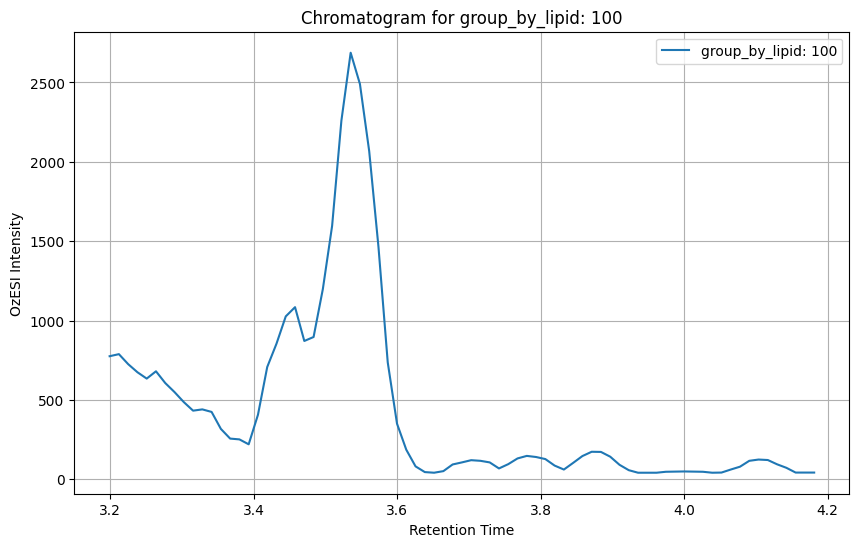

In [6]:
import matplotlib.pyplot as plt

# Function to plot the chromatogram for a specific group_by_lipid value
def plot_chromatogram(df, group_value):
    group_data = df[df['group_by_lipid'] == group_value]
    
    # Ensure the Retention_Time is sorted
    group_data = group_data.sort_values(by='Retention_Time')
    
    plt.figure(figsize=(10, 6))
    plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label=f'group_by_lipid: {group_value}')
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')
    plt.title(f'Chromatogram for group_by_lipid: {group_value}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the specific group_by_lipid value you are interested in
specific_group_by_lipid_value = 100  # Replace with the actual value you are interested in

# Call the function to plot the chromatogram
plot_chromatogram(df_grouped, specific_group_by_lipid_value)


In [7]:
df_grouped.to_csv('OzON_Grouped_06jul24_v2_RT05.csv', index=False)
df_grouped

,Lipid,Parent_Ion,Product_Ion,Retention_Time,OzESI_Intensity,Sample_ID,Transition,Sample,Species,Class,Possible_Lipids,Biology,Genotype,Cage,Mouse,group_by_ion,group_by_lipid
979787,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
1516181,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
2256899,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
2588978,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
2921073,FA(10:1)_<>_n-2,325.2,183.0,3.537000,216.0,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,325.2 -> 183.0,WT_m1_cereb_FAD245,10:1,FA,FA(9:0) | FA(10:1)_<>_n-2 | FA(12:1)_<>_n-4 | ...,cereb,WT,FAD245,m1,16,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8927492,FA(9:1)_<>_n-7,241.1,183.0,4.197533,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,241.1 -> 183.0,WT_m1_cortex_FAD245,9:1,FA,FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...,cortex,WT,FAD245,m1,1,879
9216989,FA(9:1)_<>_n-7,241.1,183.0,4.197533,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,241.1 -> 183.0,WT_m1_cortex_FAD245,9:1,FA,FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...,cortex,WT,FAD245,m1,1,879
9463902,FA(9:1)_<>_n-7,241.1,183.0,4.197533,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,241.1 -> 183.0,WT_m1_cortex_FAD245,9:1,FA,FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...,cortex,WT,FAD245,m1,1,879
9753399,FA(9:1)_<>_n-7,241.1,183.0,4.197533,41.0,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,241.1 -> 183.0,WT_m1_cortex_FAD245,9:1,FA,FA(8:1)_<>_n-6 | FA(9:1)_<>_n-7 | FA(10:1)_<>_...,cortex,WT,FAD245,m1,1,879


7562164    3.199233
8456189    3.199233
7562165    3.212150
8456190    3.212150
7562166    3.225083
             ...   
8456263    4.155333
7562239    4.168250
8456264    4.168250
7562240    4.181183
8456265    4.181183
Name: Retention_Time, Length: 154, dtype: float64


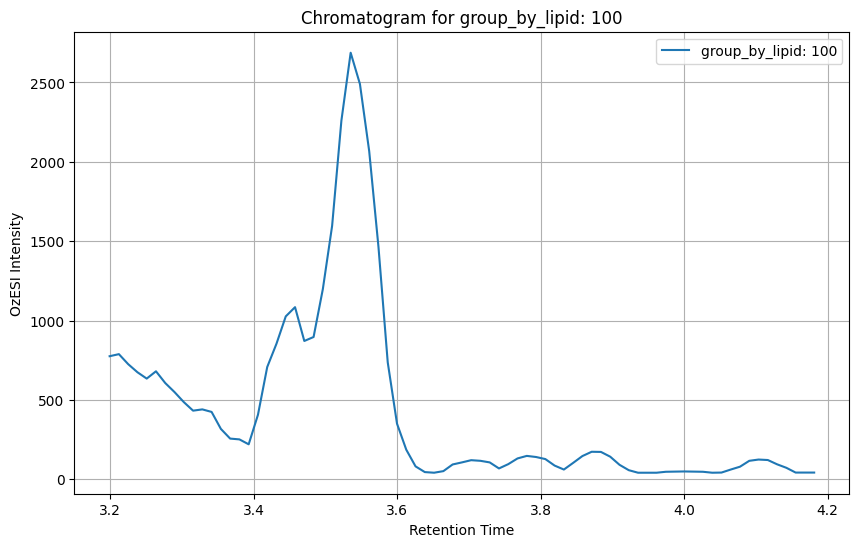

In [8]:
test = df_grouped[df_grouped['group_by_lipid'] == 100]['Retention_Time']
test.to_csv('test.csv', index=False)
import matplotlib.pyplot as plt

# Define the specific group_by_lipid value you are interested in
specific_group_by_lipid_value = 100  # Replace with the actual value you are interested in

# Print the Retention_Time values for the specific group_by_lipid value
print(df_grouped[df_grouped['group_by_lipid'] == specific_group_by_lipid_value]['Retention_Time'])

# Plot the chromatogram for the specific group_by_lipid value
def plot_chromatogram(df, group_value):
    group_data = df[df['group_by_lipid'] == group_value]
    plt.figure(figsize=(10, 6))
    plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label=f'group_by_lipid: {group_value}')
    plt.xlabel('Retention Time')
    plt.ylabel('OzESI Intensity')
    plt.title(f'Chromatogram for group_by_lipid: {group_value}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function to plot the chromatogram
plot_chromatogram(df_grouped, specific_group_by_lipid_value)


# Lipid analysis after grouping

In [9]:
import os
import pandas as pd
from tqdm import tqdm
from scipy.signal import find_peaks, peak_widths
import re

class LipidAnalysis:
    def __init__(self, data):
        self.data = data
        self.height = 1000
        self.width = None
        self.rel_height = 0.5

    # Function to extract the carbon number and double bond count
    @staticmethod
    def extract_species_info(species):
        parts = species.split(':')
        carbon_number = float(parts[0].replace('d2-', '').replace('inf', '0')) if parts[0].isdigit() else float('inf')
        double_bond = float(parts[1]) if len(parts) > 1 and parts[1].isdigit() else float('inf')
        return carbon_number, double_bond

    @staticmethod
    def extract_lipid_info(lipid):
        match = re.match(r'FA\((\d+):(\d+)\)', lipid)
        if match:
            return int(match.group(1)), int(match.group(2))
        else:
            return float('inf'), float('inf')  # Return a large number to push unknown formats to the end

    @staticmethod
    def create_folder(directory):
        if not os.path.exists(directory):
            os.makedirs(directory)

    def set_parameters(self, height=1000, width=None, rel_height=0.5):
        self.height = height
        self.width = width
        self.rel_height = rel_height

    def find_lipid_peaks(self, data=None, file_path=None, peak_analysis_csv=None, user_input="OFF", max_peaks=False):
        if user_input not in ["ON", "OFF"]:
            raise ValueError("user_input must be 'ON' or 'OFF'")
        
        if data is None and file_path is None:
            raise ValueError("Either data (DataFrame) or file_path (CSV file path) must be provided")
        
        if data is not None:
            self.data = data
        else:
            self.data = pd.read_csv(file_path)

        peak_data = []

        for filter_col in ['group_by_lipid']:
            unique_groups = self.data[filter_col].unique()

            for group in tqdm(unique_groups, desc=f"Processing {filter_col} groups"):
                group_data = self.data[self.data[filter_col] == group]
                peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=self.height, width=self.width)
                results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=self.rel_height)

                # Calculate sampling interval
                retention_times = group_data['Retention_Time'].values
                if len(retention_times) > 1:
                    sampling_interval = retention_times[1] - retention_times[0]
                else:
                    sampling_interval = 1  # Fallback value in case there's only one retention time

                for i, peak in enumerate(peaks):
                    metadata = group_data.iloc[peak][['Parent_Ion', 'Product_Ion', 'Sample', 'Species', 'group_by_lipid', 'group_by_ion', 'Biology', 'Genotype', 'Cage', 'Mouse', 'Lipid']]
                    left_ip = results_half[2][i]
                    right_ip = results_half[3][i]
                    left_time = group_data['Retention_Time'].iloc[int(left_ip)]
                    right_time = group_data['Retention_Time'].iloc[int(right_ip)]
                    width_in_time = right_time - left_time

                    fwhm = results_half[0][i] * sampling_interval

                    peak_data.append({
                        'Lipid': metadata['Lipid'],
                        'Retention_Time': group_data.iloc[peak]['Retention_Time'],
                        'OzESI_Intensity': group_data.iloc[peak]['OzESI_Intensity'],
                        'group_by_ion': metadata['group_by_ion'],
                        'group_by_lipid': metadata['group_by_lipid'],
                        'Sample_ID': group_data.iloc[peak]['Sample_ID'],
                        'Transition': group_data.iloc[peak]['Transition'],
                        'Sample': metadata['Sample'],
                        'Parent_Ion': metadata['Parent_Ion'],
                        'Product_Ion': metadata['Product_Ion'],
                        'Species': metadata['Species'],
                        'Class': group_data.iloc[peak]['Class'],
                        'Possible_Lipids': group_data.iloc[peak]['Possible_Lipids'],
                        'Biology': metadata['Biology'],
                        'Genotype': metadata['Genotype'],
                        'Cage': metadata['Cage'],
                        'Mouse': metadata['Mouse'],
                        'Peak_Height': properties['peak_heights'][i],
                        'FWHM': fwhm,
                        'Peak_Width': width_in_time,
                        'Peak_Area': properties['peak_heights'][i] * width_in_time,
                        'Filter_Column': filter_col  # Track which column was used for filtering
                    })

        peaks_df = pd.DataFrame(peak_data)

        # Ensure the directory for the CSV file exists
        csv_data_folder = os.path.dirname(peak_analysis_csv)
        self.create_folder(csv_data_folder)

        # Apply sorting
        peaks_df['species_sort'] = peaks_df['Species'].apply(self.extract_species_info)
        peaks_df = peaks_df.sort_values(by=['species_sort', 'Parent_Ion','Sample'], ascending=[True, False,True]).drop(columns='species_sort')

        # Save the DataFrame to the CSV file
        peaks_df.to_csv(peak_analysis_csv, index=False)
        
        if max_peaks:
            # Create second DataFrame and CSV for max values
            max_peaks_df = self.create_max_peaks_df(peaks_df)
            max_csv_filename = self.add_suffix_to_filename(peak_analysis_csv, '_max')
            max_peaks_df.to_csv(max_csv_filename, index=False)
            return max_peaks_df
        else:
            return peaks_df

    def create_max_peaks_df(self, peaks_df):
        # Sort by highest OzESI_Intensity first
        sorted_df = peaks_df.sort_values(by='OzESI_Intensity', ascending=False)
        
        # Filter by group_by_lipid and Sample for only the highest OzESI_Intensity value for each group_by_lipid and Sample
        max_peaks_df = sorted_df.groupby(['group_by_lipid', 'Sample']).first().reset_index()
        
        # Apply the same sorting as peaks_df
        max_peaks_df['species_sort'] = max_peaks_df['Species'].apply(self.extract_species_info)
        max_peaks_df = max_peaks_df.sort_values(by=['species_sort', 'Parent_Ion', 'Sample'], ascending=[True, False, True]).drop(columns='species_sort')

        # Ensure Lipid column is the first column
        columns = ['Lipid'] + [col for col in max_peaks_df.columns if col != 'Lipid']
        max_peaks_df = max_peaks_df[columns]

        return max_peaks_df

    @staticmethod
    def add_suffix_to_filename(filename, suffix):
        base, ext = os.path.splitext(filename)
        return f"{base}{suffix}{ext}"




    def plot_peaks(self, peaks_df, project_results=None, file_name_to_save=None):
        unique_lipids = peaks_df['Lipid'].unique()

        for lipid in unique_lipids:
            lipid_data = peaks_df[peaks_df['Lipid'] == lipid]
            plt.figure(figsize=(10, 6))

            plt.plot(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], label=lipid)
            plt.scatter(lipid_data['Retention_Time'], lipid_data['OzESI_Intensity'], color='red')

            for _, row in lipid_data.iterrows():
                plt.annotate(f"Peak Height: {row['Peak_Height']:.2f}\nFWHM: {row['FWHM']:.2f}\nArea: {row['Peak_Area']:.2f}",
                             (row['Retention_Time'], row['OzESI_Intensity']),
                             textcoords="offset points",
                             xytext=(0, 10),
                             ha='center')

            plt.title(f"Peaks for Lipid: {lipid}")
            plt.xlabel('Retention Time')
            plt.ylabel('OzESI Intensity')
            plt.legend()
            plt.grid(True)

            plot_folder = f'{project_results}plots/'
            self.create_folder(plot_folder)
            plt.savefig(f"{plot_folder}{file_name_to_save}_{lipid}_peaks.png")
            plt.close()

    def plot_data_and_peaks(self, group_type, group_value, height=1000, width=None, rel_height=0.5):
        if group_type not in ['group_by_ion', 'group_by_lipid']:
            raise ValueError(f"group_type must be 'group_by_ion' or 'group_by_lipid'")

        if group_type not in self.data.columns:
            raise ValueError(f"group_type '{group_type}' is not a valid column in the data")

        group_data = self.data[self.data[group_type] == group_value]
        peaks, properties = find_peaks(group_data['OzESI_Intensity'], height=height, width=width)
        results_half = peak_widths(group_data['OzESI_Intensity'], peaks, rel_height=rel_height)

        plt.figure(figsize=(10, 6))
        plt.plot(group_data['Retention_Time'], group_data['OzESI_Intensity'], label='Intensity')
        plt.scatter(group_data['Retention_Time'].iloc[peaks], group_data['OzESI_Intensity'].iloc[peaks], color='red')

        # Annotate peaks
        for i, peak in enumerate(peaks):
            left_ip = results_half[2][i]
            right_ip = results_half[3][i]
            left_time = group_data['Retention_Time'].iloc[int(left_ip)]
            right_time = group_data['Retention_Time'].iloc[int(right_ip)]
            width_in_time = right_time - left_time

            fwhm = results_half[0][i] * (group_data['Retention_Time'].values[1] - group_data['Retention_Time'].values[0])

            plt.annotate(f"Peak Height: {properties['peak_heights'][i]:.2f}\nFWHM: {fwhm:.2f}\nArea: {properties['peak_heights'][i] * width_in_time:.2f}",
                        (group_data['Retention_Time'].iloc[peak], group_data['OzESI_Intensity'].iloc[peak]),
                        textcoords="offset points",
                        xytext=(0, 10),
                        ha='center')

        if group_type == 'group_by_lipid':
            lipid_value = group_data['Lipid'].iloc[0] if 'Lipid' in group_data.columns else 'Unknown'
            plot_title = f"Lipid: {lipid_value}"
        else:  # group_type == 'group_by_ion'
            parent_ion_value = group_data['Parent_Ion'].iloc[0] if 'Parent_Ion' in group_data.columns else 'Unknown'
            plot_title = f"Parent Ion: {parent_ion_value}"

        plt.title(f"Peaks for {plot_title}")
        plt.xlabel('Retention Time')
        plt.ylabel('OzESI Intensity')
        plt.legend()
        plt.grid(True)
        plt.show()


# Example usage:
# Initialize your LipidAnalysis class with some data
analysis = LipidAnalysis(df_grouped)



In [10]:
# Set parameters before calling the find_lipid_peaks method
analysis.set_parameters(height=300, width=None, rel_height=0.5)

peak_analysis_csv = f"{csv_data_folder}{project_data_name}_PeakAnalysis_07jul24{mode}.csv"  # Path to the PeakAnalysis output CSV file

# Call the find_lipid_peaks method
peaks_df = analysis.find_lipid_peaks(data=df_grouped, peak_analysis_csv=peak_analysis_csv, user_input=mode, max_peaks=True)


Processing group_by_lipid groups: 100%|██████████| 880/880 [00:03<00:00, 255.03it/s]


In [11]:
peaks_df
#print type of peaks_df


,Lipid,group_by_lipid,Sample,Retention_Time,OzESI_Intensity,group_by_ion,Sample_ID,Transition,Parent_Ion,Product_Ion,...,Possible_Lipids,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area,Filter_Column
446,FA(8:1)_<>_n-2,858,WT_m1_cereb_FAD245,3.344000,10529.0,8,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cereb,WT,FAD245,m1,10529.0,0.0,0.064617,680.348883,group_by_lipid
447,FA(8:1)_<>_n-2,859,WT_m1_cortex_FAD245,3.343983,12221.0,9,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cortex,WT,FAD245,m1,12221.0,0.0,0.064600,789.476600,group_by_lipid
448,FA(9:1)_<>_n-2,868,WT_m1_cereb_FAD245,3.602000,50798.0,12,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,311.3 -> 183.0,311.3,183.0,...,FA(8:0) | FA(9:1)_<>_n-2 | FA(10:1)_<>_n-3 | F...,cereb,WT,FAD245,m1,50798.0,0.0,0.064600,3281.550800,group_by_lipid
449,FA(9:1)_<>_n-2,869,WT_m1_cortex_FAD245,3.601983,61497.0,13,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,311.3 -> 183.0,311.3,183.0,...,FA(8:0) | FA(9:1)_<>_n-2 | FA(10:1)_<>_n-3 | F...,cortex,WT,FAD245,m1,61497.0,0.0,0.064600,3972.706200,group_by_lipid
450,FA(9:1)_<>_n-3,870,WT_m1_cereb_FAD245,3.344000,10529.0,8,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cereb,WT,FAD245,m1,10529.0,0.0,0.064617,680.348883,group_by_lipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,FA(22:6)_<FFFFF>_n-10,831,WT_m1_cortex_FAD245,5.718483,572.0,37,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,381.3 -> 183.0,381.3,183.0,...,FA(13:0) | FA(14:1)_<>_n-2 | FA(15:1)_<>_n-3 |...,cortex,WT,FAD245,m1,572.0,0.0,0.025833,14.776667,group_by_lipid
428,FA(22:6)_<BFFFF>_n-10,811,WT_m1_cortex_FAD245,5.938333,303.0,35,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,379.3 -> 183.0,379.3,183.0,...,FA(15:2)_<B>_n-3 | FA(15:3)_<BF>_n-3 | FA(16:2...,cortex,WT,FAD245,m1,303.0,0.0,0.064617,19.578850,group_by_lipid
435,FA(22:6)_<FFFFF>_n-11,832,WT_m1_cereb_FAD245,5.667433,345.0,30,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,367.3 -> 183.0,367.3,183.0,...,FA(12:0) | FA(13:1)_<>_n-2 | FA(14:1)_<>_n-3 |...,cereb,WT,FAD245,m1,345.0,0.0,0.064600,22.287000,group_by_lipid
436,FA(22:6)_<FFFFF>_n-13,837,WT_m1_cortex_FAD245,6.056050,428.0,21,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,339.3 -> 183.0,339.3,183.0,...,FA(10:0) | FA(12:1)_<>_n-3 | FA(13:1)_<>_n-4 |...,cortex,WT,FAD245,m1,428.0,0.0,0.077517,33.177133,group_by_lipid


In [12]:
# Sorting the DataFrame by Peak_Area in ascending order and selecting the top 10 rows
min_10_peak_area_rows = peaks_df.nsmallest(10, 'Peak_Area')

# Printing the DataFrame with the top 10 minimum Peak_Area values
min_10_peak_area_rows


,Lipid,group_by_lipid,Sample,Retention_Time,OzESI_Intensity,group_by_ion,Sample_ID,Transition,Parent_Ion,Product_Ion,...,Possible_Lipids,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area,Filter_Column
429,FA(22:6)_<BFFFF>_n-7,825,WT_m1_cortex_FAD245,6.543533,321.0,55,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,421.4 -> 183.0,421.4,183.0,...,FA(18:2)_<B>_n-3 | FA(18:3)_<BF>_n-3 | FA(18:4...,cortex,WT,FAD245,m1,321.0,0.0,0.012917,4.146250,group_by_lipid
357,FA(20:4)_<BFF>_n-6,641,WT_m1_cortex_FAD245,8.042917,348.0,49,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,407.3 -> 183.0,407.3,183.0,...,FA(16:2)_<B>_n-2 | FA(18:2)_<B>_n-4 | FA(18:3)...,cortex,WT,FAD245,m1,348.0,0.0,0.012917,4.495000,group_by_lipid
373,FA(20:4)_<FFF>_n-15,658,WT_m1_cereb_FAD245,8.034300,359.0,6,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,283.2 -> 183.0,283.2,183.0,...,FA(6:0) | FA(8:1)_<>_n-3 | FA(9:1)_<>_n-4 | FA...,cereb,WT,FAD245,m1,359.0,0.0,0.012917,4.637083,group_by_lipid
260,FA(20:1)_<>_n-14,467,WT_m1_cortex_FAD245,10.036717,365.0,9,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cortex,WT,FAD245,m1,365.0,0.0,0.012917,4.714583,group_by_lipid
383,FA(20:4)_<FFF>_n-8,674,WT_m1_cereb_FAD245,8.044167,430.0,36,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,381.3 -> 183.0,381.3,183.0,...,FA(13:0) | FA(14:1)_<>_n-2 | FA(15:1)_<>_n-3 |...,cereb,WT,FAD245,m1,430.0,0.0,0.012917,5.554167,group_by_lipid
370,FA(20:4)_<FFF>_n-13,655,WT_m1_cortex_FAD245,8.020750,328.0,13,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,311.3 -> 183.0,311.3,183.0,...,FA(8:0) | FA(9:1)_<>_n-2 | FA(10:1)_<>_n-3 | F...,cortex,WT,FAD245,m1,328.0,0.0,0.025850,8.478800,group_by_lipid
198,FA(18:2)_<F>_n-6,338,WT_m1_cereb_FAD245,7.966650,428.0,36,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,381.3 -> 183.0,381.3,183.0,...,FA(13:0) | FA(14:1)_<>_n-2 | FA(15:1)_<>_n-3 |...,cereb,WT,FAD245,m1,428.0,0.0,0.025833,11.056667,group_by_lipid
189,FA(18:2)_<F>_n-13,323,WT_m1_cortex_FAD245,7.956750,457.0,7,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,283.2 -> 183.0,283.2,183.0,...,FA(6:0) | FA(8:1)_<>_n-3 | FA(9:1)_<>_n-4 | FA...,cortex,WT,FAD245,m1,457.0,0.0,0.025833,11.805833,group_by_lipid
374,FA(20:4)_<FFF>_n-15,659,WT_m1_cortex_FAD245,7.956750,457.0,7,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,283.2 -> 183.0,283.2,183.0,...,FA(6:0) | FA(8:1)_<>_n-3 | FA(9:1)_<>_n-4 | FA...,cortex,WT,FAD245,m1,457.0,0.0,0.025833,11.805833,group_by_lipid
38,FA(15:1)_<>_n-4,86,WT_m1_cereb_FAD245,5.744950,312.0,30,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,367.3 -> 183.0,367.3,183.0,...,FA(12:0) | FA(13:1)_<>_n-2 | FA(14:1)_<>_n-3 |...,cereb,WT,FAD245,m1,312.0,0.0,0.038750,12.090000,group_by_lipid


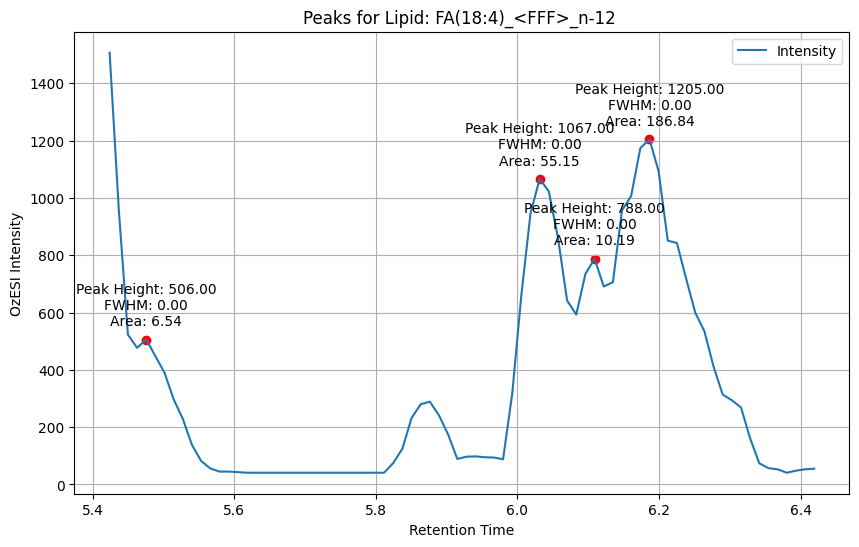

In [13]:

analysis.plot_data_and_peaks(group_type='group_by_lipid', group_value=437, height=500, width=2, rel_height=0.5)

In [15]:
peaks_df

,Lipid,group_by_lipid,Sample,Retention_Time,OzESI_Intensity,group_by_ion,Sample_ID,Transition,Parent_Ion,Product_Ion,...,Possible_Lipids,Biology,Genotype,Cage,Mouse,Peak_Height,FWHM,Peak_Width,Peak_Area,Filter_Column
446,FA(8:1)_<>_n-2,858,WT_m1_cereb_FAD245,3.344000,10529.0,8,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cereb,WT,FAD245,m1,10529.0,0.0,0.064617,680.348883,group_by_lipid
447,FA(8:1)_<>_n-2,859,WT_m1_cortex_FAD245,3.343983,12221.0,9,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cortex,WT,FAD245,m1,12221.0,0.0,0.064600,789.476600,group_by_lipid
448,FA(9:1)_<>_n-2,868,WT_m1_cereb_FAD245,3.602000,50798.0,12,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,311.3 -> 183.0,311.3,183.0,...,FA(8:0) | FA(9:1)_<>_n-2 | FA(10:1)_<>_n-3 | F...,cereb,WT,FAD245,m1,50798.0,0.0,0.064600,3281.550800,group_by_lipid
449,FA(9:1)_<>_n-2,869,WT_m1_cortex_FAD245,3.601983,61497.0,13,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,311.3 -> 183.0,311.3,183.0,...,FA(8:0) | FA(9:1)_<>_n-2 | FA(10:1)_<>_n-3 | F...,cortex,WT,FAD245,m1,61497.0,0.0,0.064600,3972.706200,group_by_lipid
450,FA(9:1)_<>_n-3,870,WT_m1_cereb_FAD245,3.344000,10529.0,8,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,297.2 -> 183.0,297.2,183.0,...,FA(7:0) | FA(8:1)_<>_n-2 | FA(9:1)_<>_n-3 | FA...,cereb,WT,FAD245,m1,10529.0,0.0,0.064617,680.348883,group_by_lipid
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
434,FA(22:6)_<FFFFF>_n-10,831,WT_m1_cortex_FAD245,5.718483,572.0,37,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,381.3 -> 183.0,381.3,183.0,...,FA(13:0) | FA(14:1)_<>_n-2 | FA(15:1)_<>_n-3 |...,cortex,WT,FAD245,m1,572.0,0.0,0.025833,14.776667,group_by_lipid
428,FA(22:6)_<BFFFF>_n-10,811,WT_m1_cortex_FAD245,5.938333,303.0,35,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,379.3 -> 183.0,379.3,183.0,...,FA(15:2)_<B>_n-3 | FA(15:3)_<BF>_n-3 | FA(16:2...,cortex,WT,FAD245,m1,303.0,0.0,0.064617,19.578850,group_by_lipid
435,FA(22:6)_<FFFFF>_n-11,832,WT_m1_cereb_FAD245,5.667433,345.0,30,11162023_WT-m1-cereb-FAD245_AMP_2x_0.05uMd216-...,367.3 -> 183.0,367.3,183.0,...,FA(12:0) | FA(13:1)_<>_n-2 | FA(14:1)_<>_n-3 |...,cereb,WT,FAD245,m1,345.0,0.0,0.064600,22.287000,group_by_lipid
436,FA(22:6)_<FFFFF>_n-13,837,WT_m1_cortex_FAD245,6.056050,428.0,21,11162023_WT-m1-cortex-FAD245_AMP_2x_0.05uMd216...,339.3 -> 183.0,339.3,183.0,...,FA(10:0) | FA(12:1)_<>_n-3 | FA(13:1)_<>_n-4 |...,cortex,WT,FAD245,m1,428.0,0.0,0.077517,33.177133,group_by_lipid


In [60]:
# Extract unique Lipid values
unique_lipids = peaks_df['Lipid'].unique()
print(unique_lipids)

# Create a new DataFrame with the unique Lipid values
unique_lipids_df = pd.DataFrame(unique_lipids, columns=['unique_lipids'])

unique_lipids_df.to_csv('AMP_unique_lipids_07jul24.csv', index=False)

['FA(8:1)_<>_n-2 ' 'FA(9:1)_<>_n-2 ' 'FA(9:1)_<>_n-3 ' 'FA(10:1)_<>_n-2 '
 'FA(10:1)_<>_n-3 ' 'FA(10:1)_<>_n-4 ' 'FA(12:1)_<>_n-2 '
 'FA(12:1)_<>_n-3 ' 'FA(12:1)_<>_n-4 ' 'FA(12:1)_<>_n-5 '
 'FA(12:1)_<>_n-6 ' 'FA(13:1)_<>_n-2 ' 'FA(13:1)_<>_n-3 '
 'FA(13:1)_<>_n-4 ' 'FA(13:1)_<>_n-5 ' 'FA(13:1)_<>_n-6 '
 'FA(13:1)_<>_n-7 ' 'FA(13:1)_<>_n-8 ' 'FA(14:1)_<>_n-2 '
 'FA(14:1)_<>_n-3 ' 'FA(14:1)_<>_n-4 ' 'FA(14:1)_<>_n-5 '
 'FA(14:1)_<>_n-6 ' 'FA(14:1)_<>_n-8 ' 'FA(15:1)_<>_n-2 '
 'FA(15:1)_<>_n-3 ' 'FA(15:1)_<>_n-4 ' 'FA(15:1)_<>_n-6 '
 'FA(15:1)_<>_n-9 ' 'FA(15:2)_<F>_n-2 ' 'FA(15:2)_<B>_n-2 '
 'FA(15:2)_<F>_n-3 ' 'FA(15:2)_<B>_n-3 ' 'FA(15:2)_<F>_n-4 '
 'FA(15:2)_<B>_n-4 ' 'FA(15:2)_<F>_n-5 ' 'FA(15:2)_<F>_n-6 '
 'FA(15:2)_<B>_n-6 ' 'FA(15:2)_<F>_n-7 ' 'FA(15:2)_<B>_n-7 '
 'FA(15:2)_<F>_n-8 ' 'FA(15:2)_<B>_n-8 ' 'FA(15:2)_<F>_n-9 '
 'FA(15:3)_<BF>_n-2 ' 'FA(15:3)_<FF>_n-3 ' 'FA(15:3)_<BF>_n-3 '
 'FA(15:3)_<BB>_n-3 ' 'FA(15:3)_<FF>_n-4 ' 'FA(15:3)_<BF>_n-4 '
 'FA(15:3)_<BB>_n-4 ' 'FA(15:3

# Plot

In [54]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

class Plot:
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def scatter(self):
        """Create scatter plots of Peak_Area by Lipid for each unique Biology and save as PNG."""
        # Assuming dataframe is already loaded
        filtered_df = self.dataframe[self.dataframe['Peak_Area'] > 0].dropna(subset=['Peak_Area'])

        if filtered_df.empty:
            print("No lipids with peak areas found. Scatter plots will not be displayed.")
            return

        # Get unique Biology values
        biology_values = filtered_df['Biology'].unique()

        for biology in tqdm(biology_values, desc="Creating scatter plots"):
            biology_df = filtered_df[filtered_df['Biology'] == biology]
            grouped = biology_df.groupby('Lipid')
            
            # Debug: Print grouped data
            #for lipid, group in grouped:
                #print(f"Biology: {biology}, Lipid: {lipid}, Data Points: {len(group)}, Peak Areas: {group['Peak_Area'].tolist()}")

            fig, ax = plt.subplots(figsize=(14, 14))
            colors = plt.cm.tab20.colors * (len(grouped) // len(plt.cm.tab20.colors) + 1)

            for (key, group), color in zip(grouped, colors):
                ax.scatter(group['Lipid'], group['Peak_Area'], label=str(key), color=color, s=100)

            ax.set_xlabel('Lipid')
            ax.set_ylabel('Peak Area')
            ax.set_title(f'Peak Area by Lipid (Biology: {biology})')
            ax.set_xticks([i for i, _ in enumerate(grouped.groups.keys())])
            ax.set_xticklabels(grouped.groups.keys(), rotation='vertical')
            ax.legend(title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
            
            # Save the figure as a PNG file
            filename = f'Peak_Area_by_Lipid_{biology}.png'
            plt.savefig(filename)
            plt.close(fig)

# Example usage
plotter = Plot(dataframe=peaks_df)
plotter.scatter()


Creating scatter plots: 100%|██████████| 2/2 [00:20<00:00, 10.19s/it]
